<a href="https://colab.research.google.com/github/wanburana/AT82.01-brain-project-group-4/blob/main/Jirasak/code_not_used/scale_selection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install mne
!gdown --id 1LoyiM9bQlrullvtoPA7X4FWhNDBGPnED
!unzip /content/data_preprocessed_python.zip -d data_preprocessed_python

     |████████████████████████████████| 7.4 MB 5.4 MB/s 
Downloading...
From: https://drive.google.com/uc?id=1LoyiM9bQlrullvtoPA7X4FWhNDBGPnED
To: /content/data_preprocessed_python.zip
100% 3.30G/3.30G [00:50<00:00, 65.3MB/s]
Archive:  /content/data_preprocessed_python.zip
 extracting: data_preprocessed_python/s01.dat  
 extracting: data_preprocessed_python/s02.dat  
 extracting: data_preprocessed_python/s03.dat  
 extracting: data_preprocessed_python/s04.dat  
 extracting: data_preprocessed_python/s05.dat  
 extracting: data_preprocessed_python/s06.dat  
 extracting: data_preprocessed_python/s07.dat  
 extracting: data_preprocessed_python/s08.dat  
 extracting: data_preprocessed_python/s09.dat  
 extracting: data_preprocessed_python/s10.dat  
 extracting: data_preprocessed_python/s11.dat  
 extracting: data_preprocessed_python/s12.dat  
 extracting: data_preprocessed_python/s13.dat  
 extracting: data_preprocessed_python/s14.dat  
 extracting: data_preprocessed_python/s15.dat  
 extra

In [ ]:
import os
from glob import glob
import pickle
import pandas as pd
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import mne
import pywt

In [ ]:
FOLDER_PATH = '/content/data_preprocessed_python/'
files_list = sorted(glob(FOLDER_PATH + '*'))

In [ ]:
features = []
targets = []

for i, f in (enumerate(tqdm(files_list))):
    with open(f, 'rb') as f: 
        content = pickle.load(f, encoding='latin1')
        data = content['data']
        labels = content['labels']
        
        n_clips, n_channels, len_features = data.shape
        
        for j in range(n_clips):
            features.append(data[j])
            targets.append(labels[j])

features = np.array(features) 
targets = np.array(targets)     

eeg_features = features[:, :32, :] # use only eeg channels
print(eeg_features.shape)

100%|██████████| 32/32 [00:04<00:00,  6.58it/s]


(1280, 32, 8064)


In [ ]:
FOLDER_PATH = '/content/drive/MyDrive/AT82.01/scale_selection'
!rm -r '$FOLDER_PATH'
os.makedirs(FOLDER_PATH, exist_ok=True)

# scale_select

data_size = eeg_features.shape[0]
n_channels = eeg_features.shape[1]
seq_len = eeg_features.shape[2]


total_scale = 64
wavelet_name ='morl'
data_start = 128 * 3
window_len = 128 * 8
overlap_len = 128 * 4

n_sliding_windows = (((seq_len - data_start) - window_len) // overlap_len) + 1

select_scale_final_output = np.zeros((data_size, total_scale,32));  
datastart = 128*3;
datalength = 8064 - datastart;

for ii in tqdm(range(0,data_size)):

    sumEER = np.zeros((total_scale,32));
    for jj in range(n_channels):
        signal = eeg_features[ii, jj, : ]
        coeff, freq = pywt.cwt(signal[datastart:], np.arange(1,total_scale+1), wavelet_name);

        energy = abs(coeff*coeff)
        scaled_energy = np.sum(energy,1)
        s = scaled_energy[:,np.newaxis]
        # s = np.tile(scaled_energy[:, np.newaxis], (1, datalength)) # ???
        p = energy/s
        entropy = -p * np.log(p)
        scaled_entropy = np.sum(entropy,1)
        EER = scaled_energy / scaled_entropy
        sumEER[:,jj] = EER
    np.save(f'{FOLDER_PATH}/selected_scale_sample_{ii:04}.npy', sumEER)
    select_scale_final_output[jj,:,:] = sumEER

rm: cannot remove '/content/drive/MyDrive/AT82.01/scale_selection': No such file or directory


100%|██████████| 1280/1280 [56:28<00:00,  2.65s/it]


In [ ]:
sumEER.shape

(64, 32)

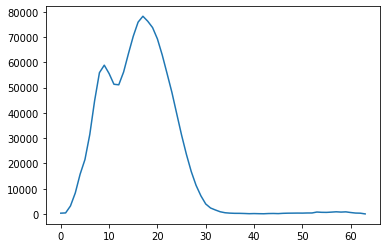

In [ ]:
plt.plot(np.mean(sumEER, 1))

In [ ]:
filelist = glob('/content/drive/MyDrive/AT82.01/scale_selection/*.npy')

In [ ]:
loaded_data = np.zeros((len(filelist), 64, 32))
for ii, f in enumerate(tqdm(filelist)):
    loaded_data[ii, :, :] = np.load(f)

100%|██████████| 1280/1280 [00:02<00:00, 478.47it/s]


In [ ]:
loaded_data.shape

(1280, 64, 32)

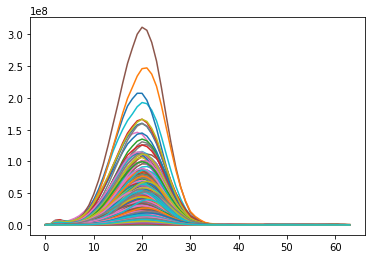

In [ ]:
for sumEER in loaded_data:
    plt.plot(np.mean(sumEER, 1))

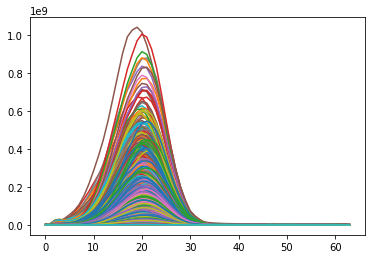

In [ ]:
for sumEER in loaded_data:
    for channel in range(32):
        plt.plot(sumEER[:,channel])

In [ ]:
sumEER.shape

(64, 32)

In [ ]:
1-36